# import

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import gc
import math
from reduce_mem_usage import reduce_mem_usage
import glob

# Japanese font setting
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP']

from sklearn.neural_network import MLPClassifier
import pickle

# enlarge plot
# plt.rcParams['figure.figsize'] = (20, 7)

# HOUR = 1
HOUR = 24

CLASSIFIER = 'neuralnet'

TARGET = 'outcome1'
# TARGET = 'dos_within_1d'
# TARGET = 'dos_within_2d'
# TARGET = 'dos_within_3d'
# TARGET = 'dos_within_1w'
# TARGET = 'dos_more_2w'

DROP_SOFA_APACHE = False

FEATURE = None
# FEATURE = ['SOFA_score', 'apache2_score', 'apache2_est_mortality']
# FEATURE = ['SOFA_score']
# FEATURE = ['apache2_score']
# FEATURE = ['apache2_est_mortality']

# read data

In [2]:
index_col = ['pID','Ent_datetime']

X_train = []
y_train = []
X_test = []
y_test = []

for i in range(10):
    # train
    if TARGET == 'outcome1':
        file_train = '../../../data/patient/imputation4/outcome1_train_{}h_{}.txt'.format(HOUR, i)
        file_test = '../../../data/patient/imputation4/outcome1_test_{}h_{}.txt'.format(HOUR, i)
    else:
        file_train = '../../../data/patient/imputation4/days_of_stay_train_{}h_{}.txt'.format(HOUR, i)
        file_test = '../../../data/patient/imputation4/days_of_stay_test_{}h_{}.txt'.format(HOUR, i)

    df_train = pd.read_table(file_train, low_memory=False, index_col=index_col)
    df_test = pd.read_table(file_test, low_memory=False, index_col=index_col)

    if TARGET == 'outcome1':
        del_cols = ['dos_within_1d', 'dos_within_2d', 'dos_within_3d', 'dos_within_1w', 'dos_more_2w']
        df_train.drop(del_cols,axis=1,inplace=True)
        df_test.drop(del_cols,axis=1,inplace=True)
    elif TARGET != 'outcome1':
        del_cols = ['dos_within_1d', 'dos_within_2d', 'dos_within_3d', 'dos_within_1w', 'dos_more_2w']
        del_cols.remove(TARGET)
        df_train.drop(del_cols,axis=1,inplace=True)
        df_test.drop(del_cols,axis=1,inplace=True)

    if DROP_SOFA_APACHE:
        drop_cols = ['SOFA_score','apache2_score','apache2_est_mortality']
        df_train.drop(drop_cols,axis=1,inplace=True)
        df_test.drop(drop_cols,axis=1,inplace=True)

    if FEATURE is not None:
        df_train = df_train[[TARGET] + FEATURE]
        df_test = df_test[[TARGET] + FEATURE]

    X_train.append(df_train.drop(TARGET,axis=1))
    y_train.append(df_train[TARGET])
    X_test.append(df_test.drop(TARGET,axis=1))
    y_test.append(df_test[TARGET])

# train

In [3]:
def train(i):

    model = MLPClassifier(
        activation='tanh',
        beta_1=0.9,
        beta_2=0.99,
        epsilon=1e-09,
        max_iter=1000,
        momentum=0.9,
        random_state=i,
        warm_start=True,
        verbose=2,
    )
    
#     if TARGET == 'outcome1':
#         params = {
#             'activation': 'tanh',
#             'alpha': 0.0001,
#             'batch_size': 'auto',
#             'beta_1': 0.8,
#             'beta_2': 0.999,
#             'early_stopping': True,
#             'epsilon': 1e-09,
#             'hidden_layer_sizes': (100,),
#             'learning_rate': 'constant',
#             'learning_rate_init': 0.001,
#             'max_fun': 15000,
#             'max_iter': 1000,
#             'momentum': 0.9,
#             'n_iter_no_change': 10,
#             'nesterovs_momentum': True,
#             'power_t': 0.5,
#             'random_state': 1,
#             'shuffle': True,
#             'solver': 'adam',
#             'tol': 0.0001,
#             'validation_fraction': 0.1,
#             'verbose': False,
#             'warm_start': False
#         }
#     elif TARGET == 'dos_within_1d':
#         params = {
#             'activation': 'tanh',
#             'alpha': 0.0001,
#             'batch_size': 'auto',
#             'beta_1': 0.9,
#             'beta_2': 0.999,
#             'early_stopping': True,
#             'epsilon': 1e-08,
#             'hidden_layer_sizes': (100,),
#             'learning_rate': 'constant',
#             'learning_rate_init': 0.001,
#             'max_fun': 15000,
#             'max_iter': 1000,
#             'momentum': 0.9,
#             'n_iter_no_change': 10,
#             'nesterovs_momentum': True,
#             'power_t': 0.5,
#             'random_state': 1,
#             'shuffle': True,
#             'solver': 'adam',
#             'tol': 0.0001,
#             'validation_fraction': 0.1,
#             'verbose': False,
#             'warm_start': False
#         }
#     elif TARGET == 'dos_within_2d':
#         params = {
#             'activation': 'tanh',
#             'alpha': 0.0001,
#             'batch_size': 'auto',
#             'beta_1': 0.8,
#             'beta_2': 0.999,
#             'early_stopping': True,
#             'epsilon': 1e-09,
#             'hidden_layer_sizes': (100,),
#             'learning_rate': 'constant',
#             'learning_rate_init': 0.001,
#             'max_fun': 15000,
#             'max_iter': 1000,
#             'momentum': 0.9,
#             'n_iter_no_change': 10,
#             'nesterovs_momentum': True,
#             'power_t': 0.5,
#             'random_state': 1,
#             'shuffle': True,
#             'solver': 'adam',
#             'tol': 0.0001,
#             'validation_fraction': 0.1,
#             'verbose': False,
#             'warm_start': False
#         }
#     elif TARGET == 'dos_within_3d':
#         params = {
#             'activation': 'tanh',
#             'alpha': 0.0001,
#             'batch_size': 'auto',
#             'beta_1': 0.9,
#             'beta_2': 0.999,
#             'early_stopping': True,
#             'epsilon': 1e-09,
#             'hidden_layer_sizes': (100,),
#             'learning_rate': 'constant',
#             'learning_rate_init': 0.001,
#             'max_fun': 15000,
#             'max_iter': 1000,
#             'momentum': 0.9,
#             'n_iter_no_change': 10,
#             'nesterovs_momentum': True,
#             'power_t': 0.5,
#             'random_state': 1,
#             'shuffle': True,
#             'solver': 'adam',
#             'tol': 0.0001,
#             'validation_fraction': 0.1,
#             'verbose': False,
#             'warm_start': False
#         }
#     elif TARGET == 'dos_within_1w':
#         params = {
#             'activation': 'tanh',
#             'alpha': 0.0001,
#             'batch_size': 'auto',
#             'beta_1': 0.8,
#             'beta_2': 0.999,
#             'early_stopping': True,
#             'epsilon': 1e-08,
#             'hidden_layer_sizes': (100,),
#             'learning_rate': 'constant',
#             'learning_rate_init': 0.001,
#             'max_fun': 15000,
#             'max_iter': 1000,
#             'momentum': 0.9,
#             'n_iter_no_change': 10,
#             'nesterovs_momentum': True,
#             'power_t': 0.5,
#             'random_state': 1,
#             'shuffle': True,
#             'solver': 'adam',
#             'tol': 0.0001,
#             'validation_fraction': 0.1,
#             'verbose': False,
#             'warm_start': False
#         }
#     elif TARGET == 'dos_more_2w':
#         params = {
#             'activation': 'tanh',
#             'alpha': 0.0001,
#             'batch_size': 'auto',
#             'beta_1': 0.9,
#             'beta_2': 0.999,
#             'early_stopping': True,
#             'epsilon': 1e-09,
#             'hidden_layer_sizes': (100,),
#             'learning_rate': 'constant',
#             'learning_rate_init': 0.001,
#             'max_fun': 15000,
#             'max_iter': 1000,
#             'momentum': 0.9,
#             'n_iter_no_change': 10,
#             'nesterovs_momentum': True,
#             'power_t': 0.5,
#             'random_state': 1,
#             'shuffle': True,
#             'solver': 'adam',
#             'tol': 0.0001,
#             'validation_fraction': 0.1,
#             'verbose': False,
#             'warm_start': False
#         }
        
#     model = MLPClassifier(**params)
    
    model.fit(X_train[i], np.array(y_train[i]))
    
    return model

model = []
for i in range(10):
    model.append(train(i))

Iteration 1, loss = 0.34190038
Iteration 2, loss = 0.20224862
Iteration 3, loss = 0.17612104
Iteration 4, loss = 0.16529836
Iteration 5, loss = 0.16057491
Iteration 6, loss = 0.15736486
Iteration 7, loss = 0.15554867
Iteration 8, loss = 0.15328074
Iteration 9, loss = 0.15215391
Iteration 10, loss = 0.15083671
Iteration 11, loss = 0.14976694
Iteration 12, loss = 0.14912117
Iteration 13, loss = 0.14837475
Iteration 14, loss = 0.14939810
Iteration 15, loss = 0.14819591
Iteration 16, loss = 0.14717898
Iteration 17, loss = 0.14917187
Iteration 18, loss = 0.14719212
Iteration 19, loss = 0.14739050
Iteration 20, loss = 0.14688288
Iteration 21, loss = 0.14736400
Iteration 22, loss = 0.14623182
Iteration 23, loss = 0.14989231
Iteration 24, loss = 0.14821579
Iteration 25, loss = 0.14586144
Iteration 26, loss = 0.14753560
Iteration 27, loss = 0.14603022
Iteration 28, loss = 0.14662711
Iteration 29, loss = 0.14671209
Iteration 30, loss = 0.14520905
Iteration 31, loss = 0.14376647
Iteration 32, los

Iteration 1, loss = 0.38825423
Iteration 2, loss = 0.22535352
Iteration 3, loss = 0.19186258
Iteration 4, loss = 0.17156207
Iteration 5, loss = 0.16234774
Iteration 6, loss = 0.15935152
Iteration 7, loss = 0.15487676
Iteration 8, loss = 0.15443949
Iteration 9, loss = 0.15243177
Iteration 10, loss = 0.15148199
Iteration 11, loss = 0.15037563
Iteration 12, loss = 0.15093108
Iteration 13, loss = 0.14953528
Iteration 14, loss = 0.14968119
Iteration 15, loss = 0.14975003
Iteration 16, loss = 0.14890330
Iteration 17, loss = 0.14878482
Iteration 18, loss = 0.14801795
Iteration 19, loss = 0.14819434
Iteration 20, loss = 0.14739356
Iteration 21, loss = 0.14897297
Iteration 22, loss = 0.14916465
Iteration 23, loss = 0.14932957
Iteration 24, loss = 0.14846303
Iteration 25, loss = 0.14812323
Iteration 26, loss = 0.14630595
Iteration 27, loss = 0.14774474
Iteration 28, loss = 0.14562193
Iteration 29, loss = 0.14741278
Iteration 30, loss = 0.14590566
Iteration 31, loss = 0.14533920
Iteration 32, los

Iteration 20, loss = 0.15136425
Iteration 21, loss = 0.15073805
Iteration 22, loss = 0.14958735
Iteration 23, loss = 0.14892510
Iteration 24, loss = 0.14873102
Iteration 25, loss = 0.14918806
Iteration 26, loss = 0.15137047
Iteration 27, loss = 0.14903331
Iteration 28, loss = 0.14779500
Iteration 29, loss = 0.14761446
Iteration 30, loss = 0.14731760
Iteration 31, loss = 0.14789723
Iteration 32, loss = 0.14759555
Iteration 33, loss = 0.14880500
Iteration 34, loss = 0.14809829
Iteration 35, loss = 0.14738285
Iteration 36, loss = 0.14824762
Iteration 37, loss = 0.14777164
Iteration 38, loss = 0.14635753
Iteration 39, loss = 0.14863597
Iteration 40, loss = 0.14662665
Iteration 41, loss = 0.14555127
Iteration 42, loss = 0.14510693
Iteration 43, loss = 0.14386377
Iteration 44, loss = 0.14567863
Iteration 45, loss = 0.14408637
Iteration 46, loss = 0.14648373
Iteration 47, loss = 0.14389562
Iteration 48, loss = 0.14486695
Iteration 49, loss = 0.14364569
Iteration 50, loss = 0.14695481
Iteratio

# grid search

In [4]:
from sklearn.model_selection import GridSearchCV

if False:
    # scoring = 'accuracy'
    scoring = 'roc_auc'

    params = {
        'activation': ['tanh'],
        'alpha': [0.0001],
        'batch_size': ['auto'],
        'beta_1': [0.9,0.8],
        'beta_2': [0.999],
        'early_stopping': [True],
        'epsilon': [1e-08,1e-09],
        'hidden_layer_sizes': [(100,)],
        'learning_rate': ['constant'],
        'learning_rate_init': [0.001],
        'max_iter': [1000],
        'momentum': [0.9,0.95],
        'n_iter_no_change': [10],
        'nesterovs_momentum': [True],
        'power_t': [0.5],
        'random_state': [1],
        'shuffle': [True],
        'solver': ['adam'],
        'tol': [0.0001],
        'validation_fraction': [0.1,0.05],
        'verbose': [False],
        'warm_start': [False,True]
    }

    gs = GridSearchCV(MLPClassifier(), params, scoring=scoring, verbose=2)
    gs.fit(X_train, y_train)

    gs_result = pd.DataFrame.from_dict(gs.cv_results_)
    model = gs.best_estimator_

#     gs_result.to_csv('../../../data/patient/union_outcome1/result/grid_search_result_outcome1_{}_group{}.txt'.format(CLASSIFIER, GROUP_NO), sep='\t', index=False)
#     pickle.dump(model, open('../../../data/patient/union_outcome1/result/model_outcome1_{}_group{}.pickle'.format(CLASSIFIER, GROUP_NO), 'wb'))

#     pred = model.predict(X_test)

    gs_result

# importance

/Users/yamabe/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/yamabe/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


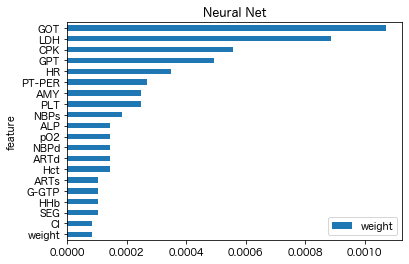

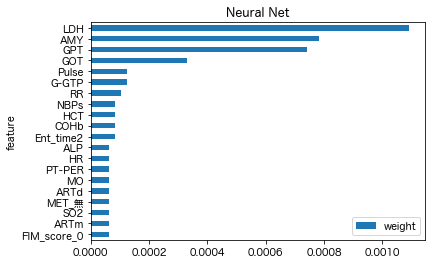

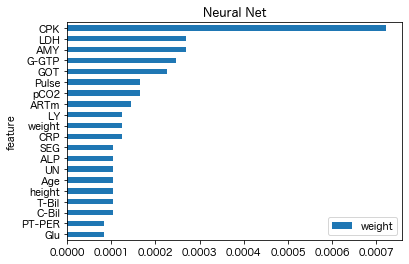

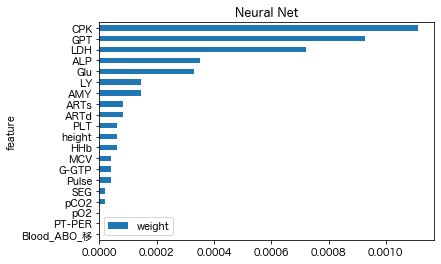

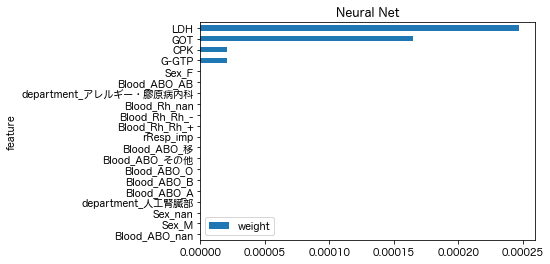

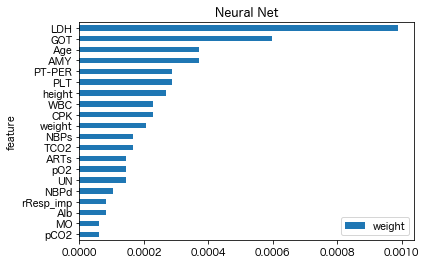

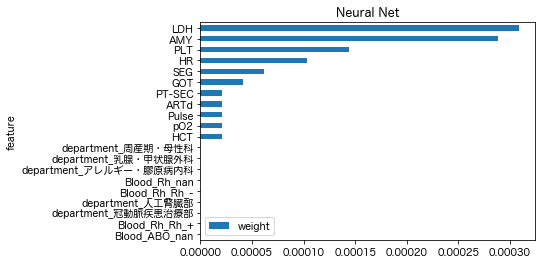

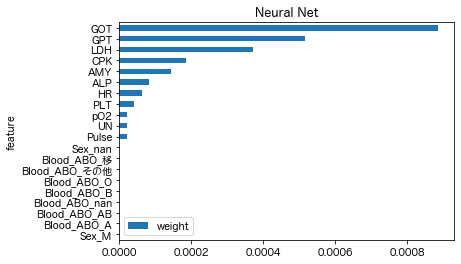

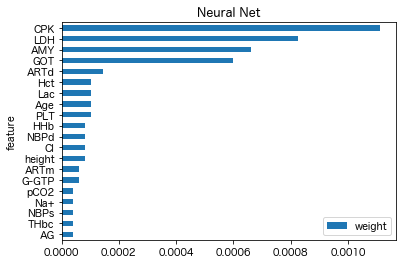

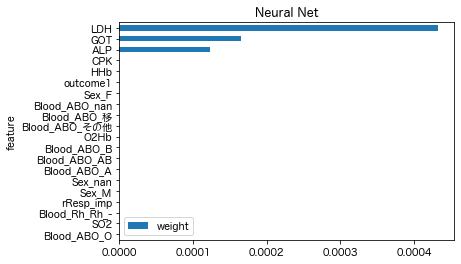

In [5]:
import eli5
from eli5.sklearn import PermutationImportance

IMPORTANCES_BASE = '../../../data/patient/imputation4/result/variable_importances/{}_{}_{}h'\
    .format(TARGET, CLASSIFIER, HOUR)

def importance(i):
    perm = PermutationImportance(model[i], random_state=i).fit(X_train[i],y_train[i])
    dfi = eli5.explain_weights_df(perm,feature_names=X_train[i].columns.tolist())

    dfi_ = dfi.head(30)

    dfi[['feature', 'weight']].to_csv('{}/variable_importances_{}_{}_{}h_{}.txt'\
        .format(IMPORTANCES_BASE,TARGET, CLASSIFIER, HOUR, i), sep='\t', index=False)

    dfi_[['feature','weight']].set_index('feature').head(20).sort_values('weight').plot.barh(title='Neural Net')
    
for i in range(10):
    importance(i)


In [7]:
# get mean
files = glob.glob('{}/*'.format(IMPORTANCES_BASE))
files.sort()

df_total = pd.DataFrame()
for f in files:
    if f.endswith('_mean.txt'):
        continue
    print(f.split('/')[-1])
    df_ = pd.read_table(f, sep='\t')
    df_total = pd.concat([df_total, df_], axis=0)

df_mean = df_total.groupby('feature', as_index=False).mean().sort_values('weight', ascending=False)
df_mean.to_csv('{}/variable_importances_{}_{}_{}h_mean.txt'\
    .format(IMPORTANCES_BASE,TARGET, CLASSIFIER, HOUR), sep='\t', index=False)

variable_importances_dos_more_2w_neuralnet_24h_0.txt
variable_importances_dos_more_2w_neuralnet_24h_1.txt
variable_importances_dos_more_2w_neuralnet_24h_2.txt
variable_importances_dos_more_2w_neuralnet_24h_3.txt
variable_importances_dos_more_2w_neuralnet_24h_4.txt
variable_importances_dos_more_2w_neuralnet_24h_5.txt
variable_importances_dos_more_2w_neuralnet_24h_6.txt
variable_importances_dos_more_2w_neuralnet_24h_7.txt
variable_importances_dos_more_2w_neuralnet_24h_8.txt
variable_importances_dos_more_2w_neuralnet_24h_9.txt


# ROC

AUC= 0.7583842901247349
AUC= 0.7896876337184424
AUC= 0.7730317795537889
AUC= 0.7907021684817868
AUC= 0.7588374949963421
AUC= 0.7683686004941543
AUC= 0.7463502054375384
AUC= 0.748832479835834
AUC= 0.7692197974611326
AUC= 0.7427935824349754
AUC 95% CI= [0.74359382 0.7904739 ]


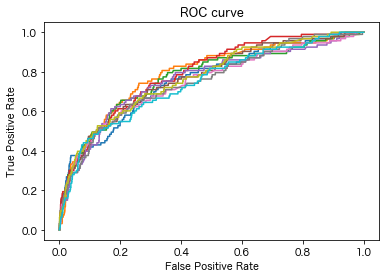

In [8]:
from sklearn import metrics
from sklearn.metrics import roc_curve

ROC_BASE = '../../../data/patient/imputation4/result/roc/{}_{}_{}h'\
    .format(TARGET, CLASSIFIER, HOUR)

def roc(i):
    pp = model[i].predict_proba(X_test[i])[:,1]
    fpr, tpr, threshold = roc_curve(y_test[i].values, pp)

    # save roc data
    df_roc = pd.DataFrame(y_test[i])
    df_roc.columns = ['test']
    df_roc['predict'] = pp
    df_roc.to_csv('{}/roc_{}_{}_{}h_{}.txt'
        .format(ROC_BASE,TARGET, CLASSIFIER, HOUR, i), sep='\t', index=False)

    # AUC
    auc = metrics.auc(fpr, tpr)
    print('AUC=', auc)

    # ROC curve
    plt.plot(fpr, tpr)
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    return auc

auc_list = []
for i in range(10):
    auc_list.append(roc(i))

print('AUC 95% CI= {}'.format(np.percentile(auc_list, (2.5, 97.5))))

In [9]:
# get mean
files = glob.glob('{}/*'.format(ROC_BASE))
files.sort()

df_total = pd.DataFrame()
for f in files:
    if f.endswith('_mean.txt'):
        continue
    print(f.split('/')[-1])
    df_ = pd.read_csv(f, sep='\t')
    df_total = pd.concat([df_total, df_], axis=0)

df_mean = df_total.reset_index().groupby('index', as_index=False).mean().drop('index',axis=1)
df_mean.to_csv('{}/roc_{}_{}_{}h_mean.txt'\
    .format(ROC_BASE,TARGET, CLASSIFIER, HOUR), sep='\t', index=False)


roc_dos_more_2w_neuralnet_24h_0.txt
roc_dos_more_2w_neuralnet_24h_1.txt
roc_dos_more_2w_neuralnet_24h_2.txt
roc_dos_more_2w_neuralnet_24h_3.txt
roc_dos_more_2w_neuralnet_24h_4.txt
roc_dos_more_2w_neuralnet_24h_5.txt
roc_dos_more_2w_neuralnet_24h_6.txt
roc_dos_more_2w_neuralnet_24h_7.txt
roc_dos_more_2w_neuralnet_24h_8.txt
roc_dos_more_2w_neuralnet_24h_9.txt


# get_params

In [15]:
model[1].get_params()

{'activation': 'tanh',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.99,
 'early_stopping': False,
 'epsilon': 1e-09,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 2,
 'warm_start': True}